 ## TensorFlow的核心学习算法
学习4个基础的机器学习算法：
- 线性回归
- 分类
- 聚类
- 隐藏Markov模型

## 线性回归 Linear Regression
引入包

In [1]:
%tensorflow_version 2.x

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from six.moves import urllib

import tensorflow as tf

### 预测泰坦尼克号生存人员
导入数据

In [3]:
dftrain = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv') # 训练集 training data
dfeval = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv') # 测试集 testing data
y_train = dftrain.pop('survived') # 提取出'survived'列，作为label
y_eval = dfeval.pop('survived')
print(dftrain['age'])  # 取出'age'该列
print(dftrain.loc[0], y_train.loc[0])  # 取出第0行的信息

0      22.0
1      38.0
2      26.0
3      35.0
4      28.0
       ... 
622    28.0
623    25.0
624    19.0
625    28.0
626    32.0
Name: age, Length: 627, dtype: float64
sex                          male
age                          22.0
n_siblings_spouses              1
parch                           0
fare                         7.25
class                       Third
deck                      unknown
embark_town           Southampton
alone                           n
Name: 0, dtype: object 0


### 数据观察

一些观察大致数据的方法

In [4]:
dftrain.describe()  # 取出一些整体的信息

,age,n_siblings_spouses,parch,fare
count,627.000000,627.000000,627.000000,627.000000
mean,29.631308,0.545455,0.379585,34.385399
std,12.511818,1.151090,0.792999,54.597730
min,0.750000,0.000000,0.000000,0.000000
25%,23.000000,0.000000,0.000000,7.895800
50%,28.000000,0.000000,0.000000,15.045800
75%,35.000000,1.000000,0.000000,31.387500
max,80.000000,8.000000,5.000000,512.329200


In [5]:
dftrain.shape  # 查看datafram的shape

(627, 9)

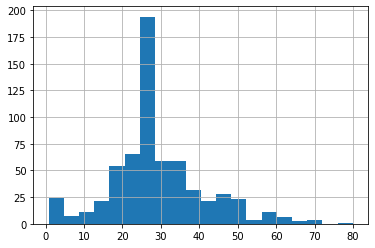

In [6]:
dftrain.age.hist(bins=20)  # 用直方图的方式查看

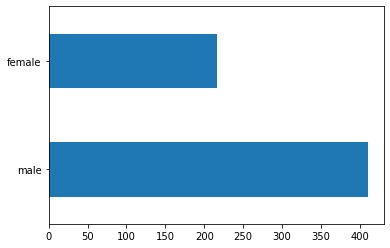

In [7]:
dftrain['sex'].value_counts().plot(kind='barh')

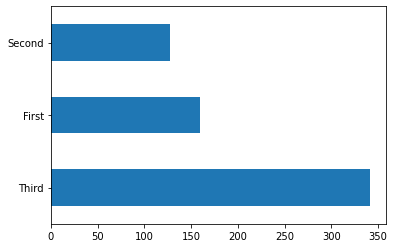

In [8]:
dftrain['class'].value_counts().plot(kind='barh')

Text(0.5, 0, '% survive')

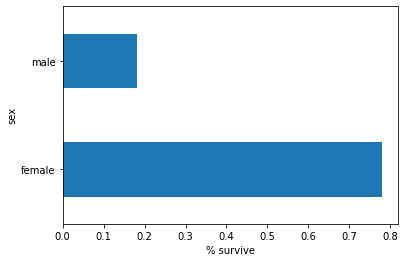

In [9]:
pd.concat([dftrain, y_train], axis=1).groupby('sex').survived.mean().plot(kind='barh').set_xlabel('% survive')

### 特征列

在特征数据内，有两种数据：**Categorical 抽象名词**和**Numeric 数字**.
- Categorical 就像 sex 列中的`male, female`（string类），parch 列（int类）.
- Numeric 当然就是具体的数字，如 ages 列中的具体浮点数（float类）.

现在我们需要先将特征从 categorical 转化为 numric 再进行训练. 这里可以利用tensorflow的特征列帮助我们完成.

In [10]:
pd.set_option('expand_frame_repr', False)  # print(df)在一行中显示出来 repr(representative) 
l = [list(dftrain.columns), [dftrain[col].dtype for col in dftrain.columns]]
print(pd.DataFrame(l))

        0        1                   2      3        4       5       6            7       8
0     sex      age  n_siblings_spouses  parch     fare   class    deck  embark_town   alone
1  object  float64               int64  int64  float64  object  object       object  object


In [11]:
categorical_col = ['sex', 'class', 'deck', 'embark_town', 'alone']  # 所有stirng和int类
numeric_col = ['age', 'n_siblings_spouses', 'parch', 'fare']  # 所有float类
feature_col = []

for name in categorical_col:
    vocabulary = dftrain[name].unique()  # 获取该列中的去重后的特征值
    feature_col.append(tf.feature_column.categorical_column_with_vocabulary_list(name, vocabulary))  # 将关键字name，和词汇表vocabulary对应
for name in numeric_col:
    feature_col.append(tf.feature_column.numeric_column(name, dtype=tf.float32))
print(feature_col)

[VocabularyListCategoricalColumn(key='sex', vocabulary_list=('male', 'female'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='class', vocabulary_list=('Third', 'First', 'Second'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='deck', vocabulary_list=('unknown', 'C', 'G', 'A', 'B', 'D', 'F', 'E'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='embark_town', vocabulary_list=('Southampton', 'Cherbourg', 'Queenstown', 'unknown'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='alone', vocabulary_list=('n', 'y'), dtype=tf.string, default_value=-1, num_oov_buckets=0), NumericColumn(key='age', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='n_siblings_spouses', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='parch', shape=(1,), defau

### 训练过程

以上已经完成了数据的准备工作，接下来进行数据的训练，具体训练过程如下：

**Mini-Batch**：对于这个特殊的模型，将会从数据集中选取一个大小为32的batch进行一次训练，而不会一次使用整个数据集进行一次更新. 每个batch的大小称为batch size.

**epoch**：表示完整训练集学习的次数，也就是我们的模型会将利用训练集总共训练epoch次


### 输入函数 Input Function

解释在每一个echo下，如何将数据分到不同的batch当中，再用于模型训练当中.

我们需要将得到的数据转化为 `tf.data.Dataset` 类型，下列函数具体应用在 [API - Dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) 中查看，学习 [Dataset 教程](https://tensorflow.google.cn/guide/data).

#### Dataset 类
我们会使用到其中几个api：
- `ds = tf.data.Dataset.range(n)` 创建一个由 `0,1,2,...,n` 的 `Dataset` 型数据类型.
- `ds.shuffle(n, reshuffle_each_iteration=True)` 使用buffer_size为 `n` 的缓存空间（相当于又开了一个buffer数组）每次将原数组中的元素放入到buffer中，如果放满了就**随机**弹出一个元素，然后在选一个元素放入到buffer中，直到原数组中没有元素，所以只要buffer_size不为 `1` 就会具有打乱的效果（[参考文章](https://blog.csdn.net/u011913417/article/details/106275103)）. 第二个参数表示是否在每个epoch中都进行打乱，每次访问都会将其打乱一次（英文很形象）.
- `ds.repeat(n)` 将 `ds` 中的元素复制 `n` 次，如果 `n=-1` 或者为空，则会无限次复制下去（在分类算法中会用到）.
- `ds.as_numpy_iterator()` 将 `ds` 中的元素以 `numpy` 迭代器的形式输出，套上 `list()` 我们就可以‘方便的’查看 `ds` 中的元素了！
- `ds.batch(n, drop_raminder=False)` 将 `ds` 中的数据按照大小为 `n` 进行分划，如果不能完全整分，则如果 `drop_raminder=False`（默认）则保留最后不完整部分，`drop_raminder=True` 则不保留.


In [12]:
ds = tf.data.Dataset.range(5)
print('创建一个dataset: {}'.format(list(ds.as_numpy_iterator())))
ds = ds.shuffle(5)  # buffer_size=5且在每次epoch中都是不同的
print('打乱前三个: {}'.format(list(ds.as_numpy_iterator())))
print('打乱前三个: {}'.format(list(ds.as_numpy_iterator())))
ds = ds.batch(3, drop_remainder=False)  # 即batch_size=3，以3个更新一次
print('划分为大小为5的batch: {}'.format(list(ds.as_numpy_iterator())))
ds = ds.repeat(3)  # 将ds重复三次，即epoch=3，训练3次整个训练集
print('重复三次: {}'.format(list(ds.as_numpy_iterator())))  # 每次重复都会被打乱

创建一个dataset: [0, 1, 2, 3, 4]
打乱前三个: [2, 3, 4, 0, 1]
打乱前三个: [4, 2, 3, 0, 1]
划分为大小为5的batch: [array([4, 3, 0]), array([1, 2])]
重复三次: [array([3, 4, 0]), array([2, 1]), array([0, 3, 1]), array([4, 2]), array([2, 4, 3]), array([1, 0])]


还有一种重要的创建Dataset的方法，利用张量切片进行创建：
- `tf.data.Dataset.from_tensor_slices(tensor)` 值得注意的是它是根据第一维信切片创建的，也就是说他会遍历tensors的第一维（可理解为训练数据的总数），然后以第一维对应的元素进行创建. 
- `tf.data.Dataset.from_tensor_slices((tensor1, tensor2, ...))` 如果是tuple输入形式，则会取出各个tesnor1,tensor2,...的第一维的元素创建一个tuple作为一个整体（完全符合特征与标签的对应方法）.
- 这里将tensor换成dict也是可以的，就会根据dict的key值作为第一维做切片.

具体看如下例子：

In [13]:
x = np.array([[1, 1], [2, 2], [3, 3]])  # 3组训练数据的特征向量，每个特征向量有3种特征
y = np.array([1, 2, 3])  # 3组训练数据对应的标签
ds = tf.data.Dataset.from_tensor_slices(x)  # 直接通过tensor创建dataset，则取第一维切片
print(list(ds.as_numpy_iterator()))
for i in range(x.shape[0]):  # 原理：取出第一维切片
    print(x[i], end=' ')

[array([1, 1]), array([2, 2]), array([3, 3])]
[1 1] [2 2] [3 3] 

In [14]:
ds = tf.data.Dataset.from_tensor_slices((x, y))  # 利用tuple创建dataset的方法，就可以将他们对应起来，（特征，标签）
list(ds.as_numpy_iterator())

[(array([1, 1]), 1), (array([2, 2]), 2), (array([3, 3]), 3)]

In [15]:
x = {'bike': [0, 1], 'bus': [1, 2], 'car': [2, 3]}  # 相当于一个2x3的tensor
y = [1, 2]
ds = tf.data.Dataset.from_tensor_slices(x)  # 以dict创建dataframe
print(list(ds.as_numpy_iterator()))
ds = tf.data.Dataset.from_tensor_slices((x, y))  # 以(dict, tesnor)的tuple创建datafram，使每一种特征更具有可读性
print(list(ds.as_numpy_iterator()))

[{'bike': 0, 'bus': 1, 'car': 2}, {'bike': 1, 'bus': 2, 'car': 3}]
[({'bike': 0, 'bus': 1, 'car': 2}, 1), ({'bike': 1, 'bus': 2, 'car': 3}, 2)]


 从上面对 `ds` 的操作中，我们已经看到如何划分 `batch`；根据 `ds` 重复的个数即为 `epochs`，也就是对总训练集训练的次数.
 
 下面让我们开始实现 Input Function，`input_function` 本质是没有输入的，返回训练所需的dataset，根据不同的数据集，我们可以构造一个外部函数用于生成 `input_function`.

In [16]:
def make_input_fun(data_df, label_df, epochs=10, shuffle=True, batch_size=32):
    def input_function():  # 注意这个input_function才是关键
        ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))  # 创建数据集，以(dict, tensor)形式创建
        if shuffle:  # 判断是否需要打乱
            ds = ds.shuffle(1000)
        ds = ds.batch(batch_size).repeat(epochs)  # 将数据先划分为batch，然后重复epochs次
        return ds
    return input_function  # 使得input_function能够直接返回dataset

train_input_fun = make_input_fun(dftrain, y_train)  # 获得训练的input_function
eval_input_fun = make_input_fun(dfeval, y_eval, epochs=1, shuffle=False)

### 创建模型
这里使用 linear estimator（线性估计器）去实现线性回归算法.

创建方法十分简单！

In [17]:
linear_est = tf.estimator.LinearClassifier(feature_col)  # 只需将特征列传入即可创建

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpczmse5x7', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


### 训练及验证

这里需要区分steps和epochs的区别，在训练结果中可以看到 `global step 200`，训练集中一共有627个样本，每个 `batch_size=32`，则一个epochs会运行 $\lceil 627/32\rceil=20$ 个mini batch，由于一共有 $10$ 个epochs，所以我们会更新 $20\cdot 10=200$ 次，也就正好是steps的次数，也就即使更新参数的次数.

In [18]:
linear_est.train(train_input_fun)  # 开始训练
result = linear_est.evaluate(eval_input_fun)  # 进行评估

Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
INFO:tensorflow:Calling model_fn.


/usr/local/lib/python3.7/dist-packages/tensorflow_estimator/python/estimator/canned/linear.py:1478: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  getter=tf.compat.v1.get_variable)


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpczmse5x7/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...
INFO:tensorflow:loss = 0.6931472, step = 0
INFO:tensorflow:global_step/sec: 112.541
INFO:tensorflow:loss = 0.5466059, step = 100 (0.892 sec)
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 200...
INFO:tensorflow:Saving checkpoints for 200 into /tmp/tmpczmse5x7/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 200...
INFO:tensorflow:Loss for final step: 0.3110122.
INFO:tensorflow:Calling model_fn.
IN

In [19]:
result

{'accuracy': 0.77272725,
 'accuracy_baseline': 0.625,
 'auc': 0.83464956,
 'auc_precision_recall': 0.7956413,
 'average_loss': 0.48636553,
 'global_step': 200,
 'label/mean': 0.375,
 'loss': 0.47492662,
 'precision': 0.7407407,
 'prediction/mean': 0.32238752,
 'recall': 0.6060606}

### 单个数据预测

In [20]:
result = list(linear_est.predict(eval_input_fun))  # 查看预测结果

INFO:tensorflow:Calling model_fn.


/usr/local/lib/python3.7/dist-packages/tensorflow_estimator/python/estimator/canned/linear.py:1478: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  getter=tf.compat.v1.get_variable)


INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpczmse5x7/model.ckpt-200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [21]:
id = 4
print(dfeval.loc[id])
print('真实存活情况: {}'.format(y_eval.loc[id]))
print('预测存活概率：{}'.format(result[id]['probabilities'][1]))
# result[id]['probabilities']  # 0表示死亡，1表示存活

sex                          male
age                          34.0
n_siblings_spouses              0
parch                           0
fare                         13.0
class                      Second
deck                            D
embark_town           Southampton
alone                           y
Name: 4, dtype: object
真实存活情况: 1
预测存活概率：0.21320641040802002


## 分类算法
回归算法（regression）用于预测数值，而分类算法（classification）用于将不同数据标签进行分离.

In [22]:
import tensorflow as tf
import pandas as pd

### 数据集
这个数据集将花分为以下三类：
- Setosa
- Versicolor
- Virginica

花的特征有如下几个：
- sepal length
- sepal width
- petal length
- petal width

In [23]:
columns = ['SepalLength', 'SepalWidth', 'PetalLength', 'PetalWidth', 'Species']
species = ['Setosa', 'Versicolor', 'Virginica']

这里使用另一种文件读入方式，能够保存数据（如果发现有相同的文件名就不会重复下载数据，但不会检测是否大小一致，所以需要手动更新），并返回路径地址

`path = tf.keras.utils.get_file(fname, origin, ultar=True, cashe_dir='.')` 
- path文件保存的地址
- fname为存储到本地的文件名.
- origin为文件源地址.
- ultar是否对压缩文件则进行解压.
- cashe_dir指定保存目录，`'.'` 表示当前目录下的 `datasets` 文件夹，默认保存到本地的缓存目录 `~/.keras/datasets`，`~` 为当前用户的根目录.

In [24]:
train_path = tf.keras.utils.get_file(
    "iris_training.csv", "https://storage.googleapis.com/download.tensorflow.org/data/iris_training.csv")
test_path = tf.keras.utils.get_file(
    "iris_test.csv", "https://storage.googleapis.com/download.tensorflow.org/data/iris_test.csv")

In [25]:
train = pd.read_csv(train_path, names=columns, header=0)  # 从第0行开始读入表格，并且重载列名称为columns
test = pd.read_csv(test_path, names=columns, header=0)
train

,SepalLength,SepalWidth,PetalLength,PetalWidth,Species
0,6.4,2.8,5.6,2.2,2
1,5.0,2.3,3.3,1.0,1
2,4.9,2.5,4.5,1.7,2
3,4.9,3.1,1.5,0.1,0
4,5.7,3.8,1.7,0.3,0
...,...,...,...,...,...
115,5.5,2.6,4.4,1.2,1
116,5.7,3.0,4.2,1.2,1
117,4.4,2.9,1.4,0.2,0
118,4.8,3.0,1.4,0.1,0


In [26]:
train_y = train.pop('Species')
test_y = test.pop('Species')

### Input Function & 特征列

In [27]:
def input_fn(x, y=None, training=True, batch_size=256):
    ds = tf.data.Dataset.from_tensor_slices((dict(x), y))
    if training:
        ds = ds.shuffle(1000).repeat()  # 如果是训练数据，则既要打乱，又要无限生成，用steps控制训练次数
    return ds.batch(batch_size)

In [28]:
feature = []
for col in train.columns:
    feature.append(tf.feature_column.numeric_column(col))
feature

[NumericColumn(key='SepalLength', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='SepalWidth', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='PetalLength', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='PetalWidth', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)]

### 创建模型

In [29]:
classifier = tf.estimator.DNNClassifier([64, 32], feature, n_classes=3)
clear_output()

In [30]:
classifier.train(
    lambda: input_fn(train, train_y),
    steps=5000
)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpbtbkxv6h/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...
INFO:tensorflow:loss = 1.2323792, step = 0
INFO:tensorflow:global_step/sec: 155.325
INFO:tensorflow:loss = 0.93429923, step = 100 (0.648 sec)
INFO:tensorflow:global_step/sec: 165.494
INFO:tensorflow:loss = 0.8593228, step = 200 (0.604 sec)
INFO:tensorflow:global_step/sec: 150.621
INFO:tensorflow:loss = 0.8066803, step = 300 (0.664 sec)
INFO:tensorflow:global_step/sec: 149.47
INFO:tensorflow:loss = 0.7546103, step = 400 (0.668 sec)
INFO:tensorflow:global_step/sec: 126.533
INFO:tensorflow:loss = 0.7137563, step = 500 (0.791 sec)
INFO:t

In [31]:
result = classifier.evaluate(lambda: input_fn(test, test_y, training=False))
clear_output()

In [32]:
result

{'accuracy': 0.96666664,
 'average_loss': 0.31678727,
 'global_step': 5000,
 'loss': 0.31678727}

### 自定义输入验证

In [33]:
# 自定义输入，预测
predict = {}  # 初始化字典
for col in columns[0:4]:
    valid = False
    while not valid:
        val = input(col + ': ')
        if type(eval(val)) == float: valid = True
    predict[col] = [float(val)]

SepalLength: 1.2
SepalWidth: 1.2
PetalLength: 1.2
PetalWidth: 1.2


In [34]:
result = list(classifier.predict(lambda: input_fn(predict, training=False)))
def print_pred(dic):
    class_id = dic['class_ids'][0]
    probability = dic['probabilities'][class_id]
    print('预测为 "{}" ({:.2f}%)'.format(species[class_id], 100 * probability))
print_pred(result[0])

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpbtbkxv6h/model.ckpt-5000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
预测为 "Versicolor" (40.62%)


In [35]:
# 三个小例子
expected = ['Setosa', 'Versicolor', 'Virginica']
predict_x = {
    'SepalLength': [5.1, 5.9, 6.9],
    'SepalWidth': [3.3, 3.0, 3.1],
    'PetalLength': [1.7, 4.2, 5.4],
    'PetalWidth': [0.5, 1.5, 2.1],
}
result = list(classifier.predict(lambda: input_fn(predict_x, training=False)))
for dic in result:
    print_pred(dic)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpbtbkxv6h/model.ckpt-5000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
预测为 "Setosa" (91.70%)
预测为 "Versicolor" (63.99%)
预测为 "Virginica" (67.77%)


## Clusting 聚类算法
### K-Means
这里只做简单的介绍，目标是根据数据集将整个数据集分为 $k$ 个部分，然后对于每个给出的元素，预测它所处于哪个部分.

1. 随机选 $k$ 个点设置 $k$ 个质心（centroid），用于聚类的定位.
2. 将每个点分配到距离它最近的质心上（距离可以取Euclidean距离，Manhattan距离等）.
3. 根据一个质心包含的全部点，重新计算它们的质心（center of mass）.
4. 重复2, 3步，直到每个点从属的质心不再改变（质心不再移动）.

对于每个预测的点，只需计算出距离最近的质心，即为它所预测的类别.

## 隐Markov模型
包含三个关键变量：
- states：在每个Markov模型中，有有限组states，比如：天气的hot, cold；温度的high, low；等等
- observation：每个state下都有一个与特定概率分布相关的obervation（观察的事件），比如：hot下Tim有80%高兴，20%不高兴，cold下Tim有30%高兴，70%不高兴.
- Transitions：任意两个states之间有特定的概率进行转移，比如：第一天是cold，则第二天有20%是hot，70%是cold.

创建一个Markov模型需要给定：
- states
- observation distribution
- trainsition distribution

通过前面给定的几天的信息，预测后面的status. （也就是对时间序列进行预测）


### 天气模型
这里以一个天气模型为例.

1. cold编码为0，hot编码为1.
2. 时间序列的第一天有80%的概率为cold.
3. cold有30%转化为hot.
4. hot有20%转化为cold.
5. cold day温度的均值为0，标准差为5，hot day温度的均值为15，标准差为10.

In [36]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np

#### tfp（tensorflow_probability）概率密度
下文中tensorflow中把它称为分布函数，其实是概率密度函数 $p(x)$，不是分布函数 $F(x)$.

这里会用到 `tfd = tfp.distributinos` 中的两种概率分布：
- 分布律：`tfd.Categorical(prob=[p1, p2, ..., pn])`，其中 $p_1+\cdots+p_n=1$，随机变量 $X$ 满足如下分布律：
$$
X\sim\left(\begin{matrix}1&2&\cdots&n\\p_1&p_2&\cdots&p_n\end{matrix}\right)
$$
- 正态分布：`tfd.Normal(loc, scale)`，其中 `loc` 为偏移，`scale` 为缩放，正态分布如下：
$$
N(x; \mu,\sigma) = \frac{1}{\sqrt{2\pi}\sigma}e^{-\frac{(x-\mu)^2}{2\sigma^2}}
$$
则上述的 $\text{loc} = \mu$，$\text{scale}=\sigma$，这里可以同时创建多组正态分布，只需写成向量的形式即可.

概率分布有几种通用的api：
- `dist.prob(x)` 输出概率密度函数 $p(x)$ 的值.
- `dist.cdf(x)` 输出分布函数 $F(x)$ 的值（cumulative distribution function）.
- `dist.sample(n)` 根据dist的概率分布，随机取出 $n$ 个样本.

In [37]:
tfd = tfp.distributions  #　这里的分布函数就是概率密度函数
dist = tfd.Normal(0, 1)  # 创建一个标准正态分布
print(dist.prob(0.1))  # 输出x=0.1的概率
N = lambda x: np.exp(-np.power(x, 2) / 2) / (np.sqrt(2 * np.pi))
print('验证：{}'.format(N(0.1)))
print(dist.cdf(0))  # 输出x=0的分布函数值
print(dist.sample(3))  # 以该概率分布输出3个样本
dist = tfd.Normal([0, 1], [1, 5])  # 以0, 1和1, 5为均值和标准差的两个正态分布
print(dist.cdf(0))

tf.Tensor(0.39695257, shape=(), dtype=float32)
验证：0.3969525474770118
tf.Tensor(0.5, shape=(), dtype=float32)
tf.Tensor([ 0.24239153  0.91446084 -0.9471327 ], shape=(3,), dtype=float32)
tf.Tensor([0.5       0.4207403], shape=(2,), dtype=float32)


这里引入概率分布是为了完成上述各种概率的描述，引入正态分布其实是为了满足第5条，由中心极限定理可知，$n$ 个独立同分布的随机变量，当 $n$ 充分大时，随机变量的和近似于正态分布，所以可以用正态分布近似当前的每天温度的概率分布.

In [38]:
tfd = tfp.distributions  # 缩写distribution模块
init = tfd.Categorical(probs=[0.8, 0.2])  # 第2条
transition = tfd.Categorical(probs=[[0.7, 0.3], [0.2, 0.8]])  # 第3，4条
observation = tfd.Normal([0, 15], [5, 10])  # 第5条

#### 创建隐Markov模型

参考 [tfp.distributions.HiddenMarkovModel - API](https://tensorflow.google.cn/probability/api_docs/python/tfp/distributions/HiddenMarkovModel)，可知创建一个隐Markov模型至少需要如下几个参数：
```python
tfp.distributions.HiddenMarkovModel(
    initial_distribution,  # 初始分布律
    transition_distribution,  # 转移分布律
    observation_distribution,  # 观察分布律
    num_steps,  # Markov链的长度（这里就是期望预测的天数）
}
```

In [39]:
model = tfd.HiddenMarkovModel(init, transition, observation, 7)

In [40]:
print(model.mean())  # 预期后续7天每天的温度

tf.Tensor([2.9999998 5.9999995 7.4999995 8.25      8.625001  8.812501  8.90625  ], shape=(7,), dtype=float32)


In [41]:
model.prob(tf.zeros(shape=[7]))  # 预测后续7天均为0度的概率

<tf.Tensor: shape=(), dtype=float32, numpy=2.3812634e-09>